In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from dicl.utils import calibration

from dicl.utils.main_script import prepare_data
from sklearn.decomposition import PCA

os.environ["HF_HOME"] = "/mnt/vdb/hugguingface/"

In [18]:
# df = pd.read_csv("../results/data.csv")
# index_new_exps = 4294
# df = df.iloc[index_new_exps:]

# df_newcol = df.set_axis(
#     [
#         "dataset",
#         "foundational_model",
#         "adapter",
#         "n_features",
#         "n_components",
#         "is_fine_tuned",
#         "pca_in_preprocessing",
#         "use_revin",
#         "context_length",
#         "forecasting_horizon",
#         "running_time",
#         "seed",
#         "metric",
#         "value",
#         "train_size",
#     ],
#     axis=1,
# )
# print(len(df_newcol))
# df_newcol.head()

In [19]:
df = pd.read_csv("../results/data_latest.csv")
df["adapter"] = df["adapter"].fillna("no_adapter")
df.head()

,dataset,foundational_model,adapter,n_features,n_components,is_fine_tuned,pca_in_preprocessing,use_revin,context_length,forecasting_horizon,running_time,seed,metric,value,train_size
0,Illness,AutonLab/MOMENT-1-small,linearAE,7,7,ft_then_supervised,False,True,512.0,24,1023.801718,832.0,mse,2.665083,141.0
1,Illness,AutonLab/MOMENT-1-small,linearAE,7,7,ft_then_supervised,False,True,512.0,24,1023.801718,832.0,mae,1.134758,141.0
2,Illness,AutonLab/MOMENT-1-small,linearAE,7,7,ft_then_supervised,False,True,512.0,24,1023.801718,832.0,scaled_mse,2.657057,141.0
3,Illness,AutonLab/MOMENT-1-small,linearAE,7,7,ft_then_supervised,False,True,512.0,24,1023.801718,832.0,scaled_mae,1.142708,141.0
4,Illness,AutonLab/MOMENT-1-small,linearAE,7,7,ft_then_supervised,False,True,512.0,24,601.990601,22708.0,mse,2.686855,141.0


In [24]:
ddf = df[
    (df["metric"] == "ks")
    & (df["dataset"].isin(["ETTh1", "Illness", "ExchangeRate", "Weather"]))
]
min_ece_rows = ddf.nsmallest(2, "value")
print(min_ece_rows)

     dataset       foundational_model    adapter  n_features  n_components  \
2404   ETTh1  AutonLab/MOMENT-1-small  linearVAE           7             5   
2500   ETTh1  AutonLab/MOMENT-1-small  linearVAE           7             5   

           is_fine_tuned  pca_in_preprocessing  use_revin  context_length  \
2404  ft_then_supervised                 False       True           512.0   
2500  ft_then_supervised                 False       True           512.0   

      forecasting_horizon  running_time     seed metric     value  train_size  
2404                   96   3088.297048  27786.0     ks  0.313245      8033.0  
2500                   96   1970.293519  27037.0     ks  0.318242      8033.0  


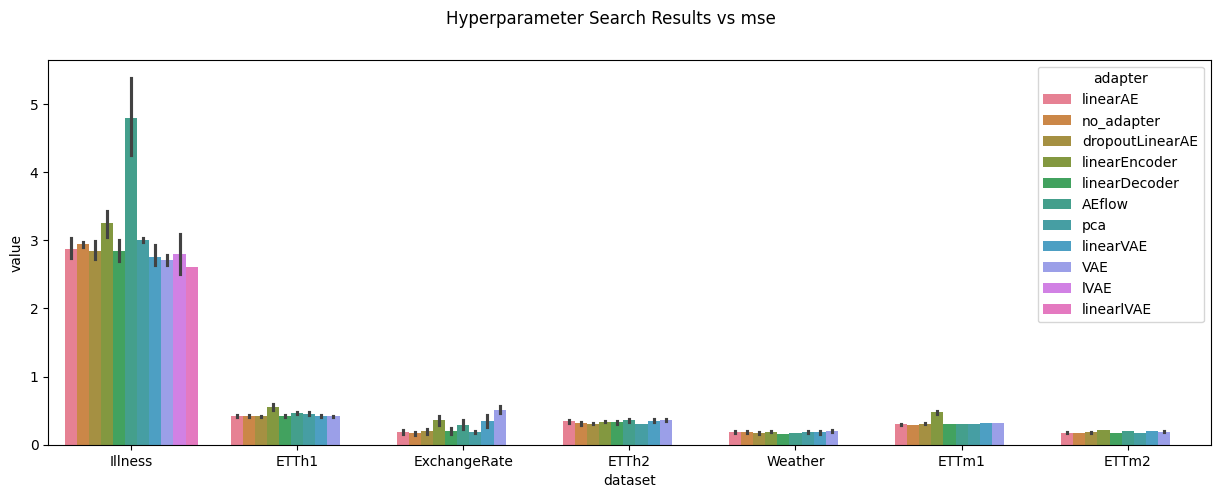

In [4]:
metric = "mse"

fig, axes = plt.subplots(1, 1, figsize=(15, 5))
# axes = axes.flatten()
fig.suptitle(f"Hyperparameter Search Results vs {metric}")

sns.barplot(
    df.loc[df["metric"] == metric], x="dataset", y="value", hue="adapter", ax=axes
)
plt.show()

In [5]:
def print_scores(
    dataset,
    adapter,
    forecasting_horizon,
    n_components,
    use_revin,
    pca_in_preprocessing,
    metric,
    train_size=None,
    is_fine_tuned="supervised",
    only_latex=True,
):
    if train_size:
        df_ = df.loc[
            (df["dataset"] == dataset)
            & (df["adapter"] == adapter)
            & (df["n_components"] == n_components)
            & (df["use_revin"] == use_revin)
            & (df["pca_in_preprocessing"] == pca_in_preprocessing)
            & (df["metric"] == metric)
            & (df["forecasting_horizon"] == forecasting_horizon)
            & (df["train_size"] == train_size)
            & (df["is_fine_tuned"] == is_fine_tuned)
        ]
    else:
        df_ = df.loc[
            (df["dataset"] == dataset)
            & (df["adapter"] == adapter)
            & (df["n_components"] == n_components)
            & (df["use_revin"] == use_revin)
            & (df["pca_in_preprocessing"] == pca_in_preprocessing)
            & (df["metric"] == metric)
            & (df["forecasting_horizon"] == forecasting_horizon)
            & (df["is_fine_tuned"] == is_fine_tuned)
        ]

    if only_latex:
        print(f"${df_['value'].mean():.3f}_{{\pm {df_['value'].sem():.3f}}}$")
    else:
        print(
            f"Dataset: {dataset}, Adapter: {adapter}, n_components: {n_components}, use_revin: {use_revin}, pca_in_preprocessing: {pca_in_preprocessing}"
        )
        print(
            f"Mean: {df_['value'].mean()}, Std: {df_['value'].std()}, Standard Error: {df_['value'].sem()}"
        )
        print(f"${df_['value'].mean():.3f}_{{\pm {df_['value'].sem():.3f}}}$")
        print(f"Min: {df_['value'].min()}, Max: {df_['value'].max()}")
        print(
            f"25th percentile: {df_['value'].quantile(0.25)}, 75th percentile: {df_['value'].quantile(0.75)}"
        )
        print(f"Median: {df_['value'].median()}")
        print("Count of seeds: ", len(df_))

In [6]:
dataset = "Weather"
adapter = "pca"
n_components = 21
use_revin = False
pca_in_preprocessing = False
forecasting_horizon = 192
train_size = None
is_fine_tuned = "ft"

for mtr in ["mse", "mae", "ks", "ece"]:
    print(f"Metric: {mtr}")
    print_scores(
        dataset,
        adapter,
        forecasting_horizon,
        n_components,
        use_revin,
        pca_in_preprocessing,
        mtr,
        train_size,
        is_fine_tuned,
    )
    print("")

Metric: mse
$0.208_{\pm 0.001}$

Metric: mae
$0.260_{\pm 0.001}$

Metric: ks
$0.573_{\pm 0.001}$

Metric: ece
$0.262_{\pm 0.001}$



In [7]:
adapter = "linearAE"
use_revin = True
pca_in_preprocessing = False
train_size = None
is_fine_tuned = "ft_then_supervised"

for mtr in ["mse", "mae", "ks", "ece"]:
    print(f"Metric: {mtr}")
    print_scores(
        dataset,
        adapter,
        forecasting_horizon,
        n_components,
        use_revin,
        pca_in_preprocessing,
        mtr,
        train_size,
        is_fine_tuned,
        only_latex=True,
    )
    print("")

Metric: mse
$0.198_{\pm 0.001}$

Metric: mae
$0.251_{\pm 0.001}$

Metric: ks
$0.568_{\pm 0.001}$

Metric: ece
$0.259_{\pm 0.000}$



### Barplot different Linear adapters

/tmp/ipykernel_3357856/3814171426.py:25: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  bar = sns.barplot(


<Figure size 640x480 with 0 Axes>

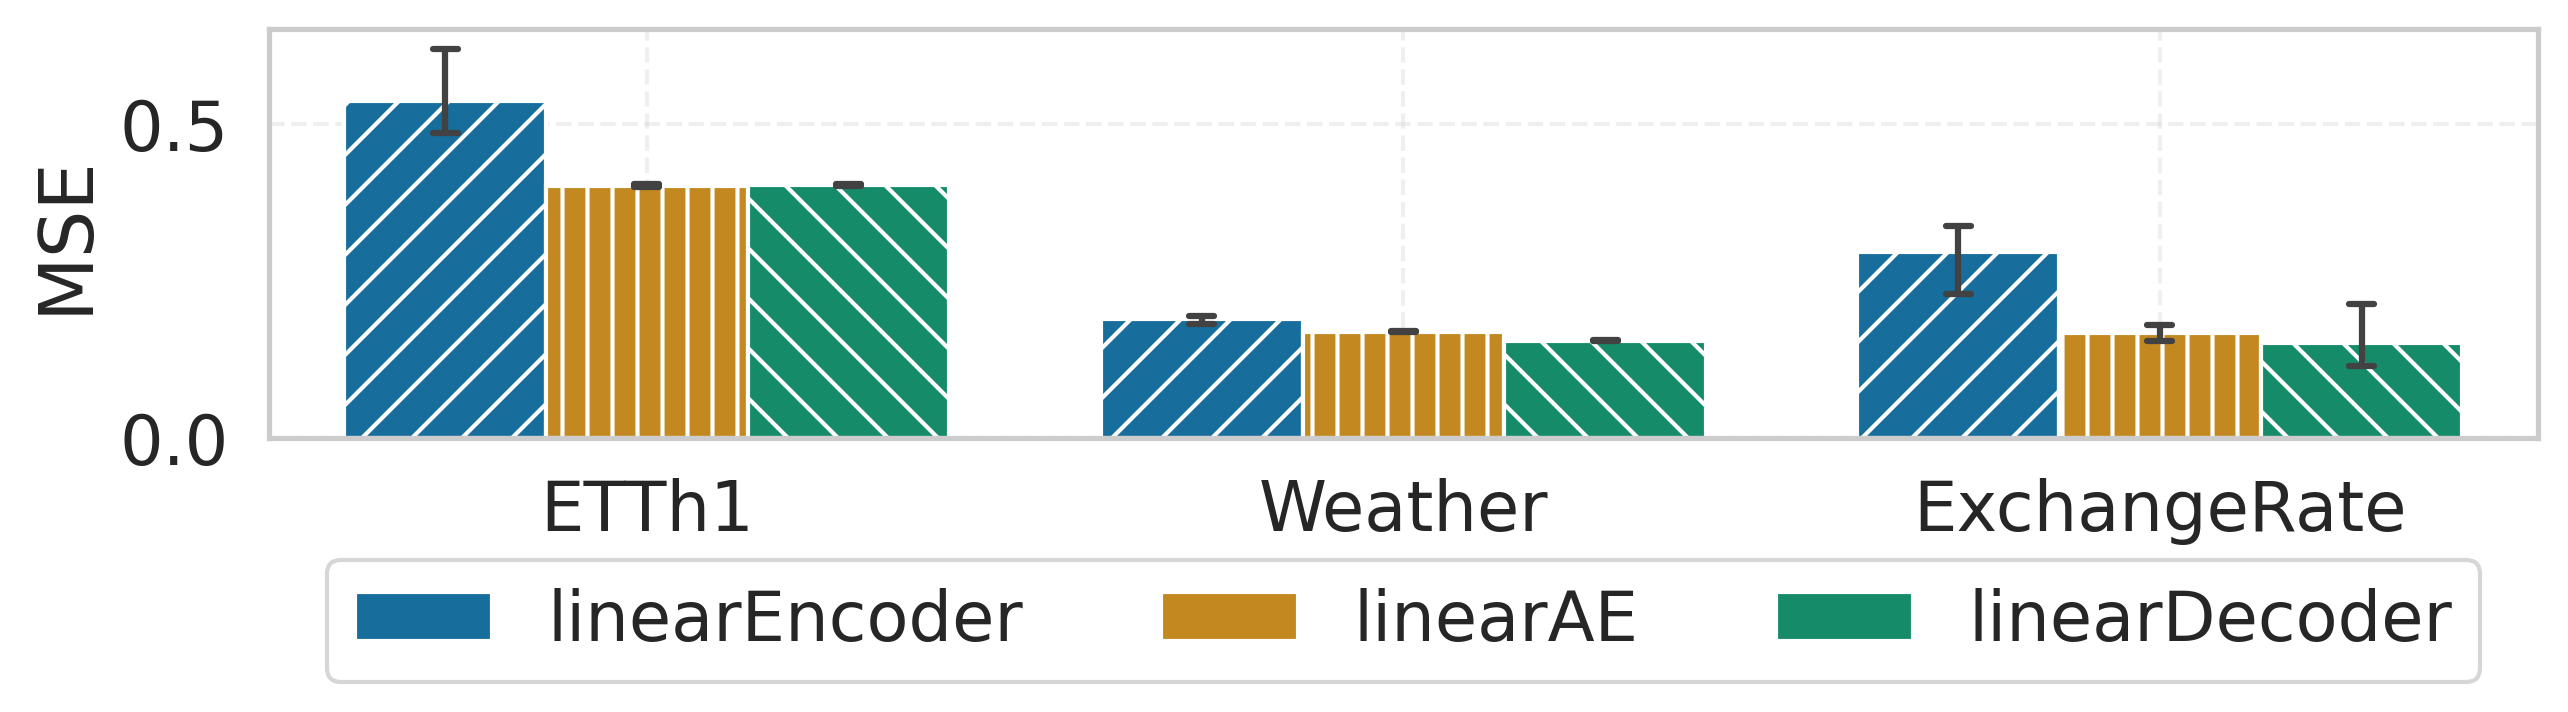

In [30]:
datasets = ["ETTh1", "Weather", "ExchangeRate"]
n_components = [7, 8, 21]
use_revin = True
pca_in_preprocessing = False
metric = "mse"
forecasting_horizon = [24, 96]

df_ = df.loc[
    (df["dataset"].isin(datasets))
    & (df["n_components"].isin(n_components))
    & (df["adapter"].isin(["linearAE", "linearEncoder", "linearDecoder"]))
    & (df["pca_in_preprocessing"] == pca_in_preprocessing)
    & (df["metric"] == metric)
    & (df["forecasting_horizon"].isin(forecasting_horizon))
    & (df["is_fine_tuned"].isin(["ft_then_supervised", "ft"]))
]

sns.set_theme(style="whitegrid", font_scale=1.5)
sns.set_palette("colorblind")
sns.despine()

fig, ax = plt.subplots(figsize=(9, 3), dpi=300)

# Create barplot
bar = sns.barplot(
    data=df_,
    x="dataset",
    y="value",
    hue="adapter",
    hue_order=[
        "linearEncoder",
        "linearAE",
        "linearDecoder",
    ],
    order=datasets,
    capsize=0.1,
    errwidth=1.5,
    palette="colorblind",
    ax=ax,
)

# Define hatches for each adapter type
hatches = ["//", "||", "\\\\"]

# Loop over the bars in the plot and set hatches
for i, bars in enumerate(bar.containers):
    for b in bars:
        b.set_hatch(hatches[i])

ax.set_ylabel("MSE")
ax.set_xlabel(None)
ax.grid(True, alpha=0.3, linestyle="--")

ax.legend(bbox_to_anchor=(0.5, -0.3), loc="upper center", borderaxespad=0.0, ncol=3)

plt.tight_layout()
plt.savefig(
    "/mnt/vdb/abenechehab/dicl-adapters/figures/from_notebooks/encoder_decoder.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

## RevIn ablation

/tmp/ipykernel_3357856/2760650344.py:22: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  bar = sns.barplot(


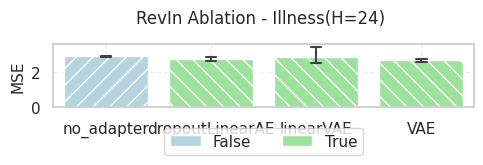

In [13]:
dataset = "Illness"
# adapter = "revin"
n_components = 7
# use_revin = False
pca_in_preprocessing = False
metric = "mse"
forecasting_horizon = 24

adapters_to_keep = [
    "no_adapter",
    "dropoutLinearAE",
    "linearVAE",
    "VAE",
]

df_ = df.loc[
    (df["dataset"] == dataset)
    & (df["n_components"] == n_components)
    & (df["pca_in_preprocessing"] == pca_in_preprocessing)
    & (df["metric"] == metric)
    & (df["forecasting_horizon"] == forecasting_horizon)
    & (df["adapter"].isin(adapters_to_keep))
]

plt.figure(figsize=(5, 2))
sns.set(style="whitegrid", color_codes=True)
bar = sns.barplot(
    df_,
    x="adapter",
    y="value",
    hue="use_revin",
    order=adapters_to_keep,
    palette=sns.color_palette(["lightblue", "lightgreen"]),
    capsize=0.1,
    errwidth=1.5,
)

hatches = ["//", "\\\\"]
# Loop over the bars
for bars, hatch in zip(bar.containers, hatches):
    # Set a different hatch for each group of bars
    for bar in bars:
        bar.set_hatch(hatch)

# Add hatching pattern to the second hue category
# bars = plt.gca().patches
# n_bars = len(df_["adapter"].unique())
# for i in range(n_bars, len(bars)):
#     bars[i].set_hatch("///")
plt.title(f"RevIn Ablation - {dataset}(H={forecasting_horizon}) ", fontsize=12, pad=15)
plt.xlabel(None)
plt.ylabel("MSE", fontsize=11)
# plt.xticks(rotation=45)
plt.legend(title_fontsize=10, bbox_to_anchor=(0.5, -0.2), loc="upper center", ncol=3)
plt.grid(True, alpha=0.3, linestyle="--")
plt.savefig(
    "/mnt/vdb/abenechehab/dicl-adapters/figures/from_notebooks/revin_illness.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.tight_layout()

## Dimensionality reduction

/tmp/ipykernel_3315033/1580397301.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["n_components"] = df_plot["n_components"].astype(int)
/tmp/ipykernel_3315033/1580397301.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot["n_components"] = df_plot["n_components"].astype(int)
/tmp/ipykernel_3315033/1580397301.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 640x480 with 0 Axes>

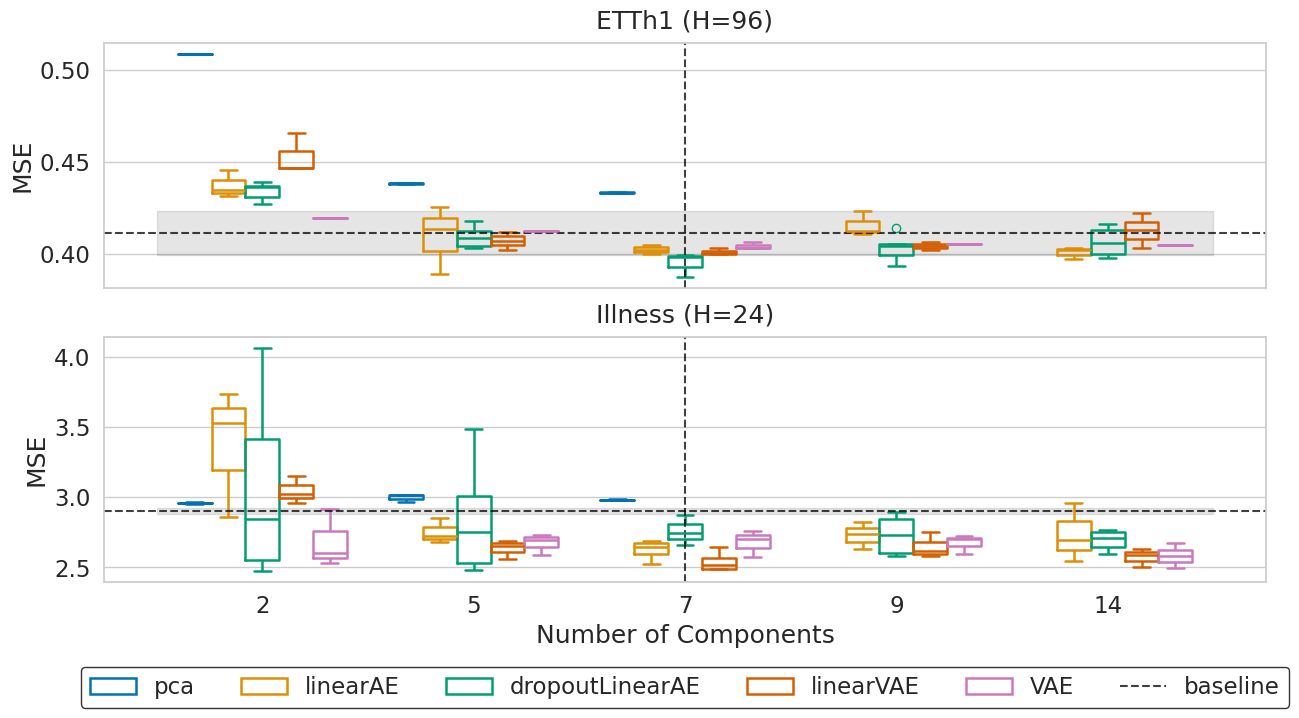

In [15]:
sns.set_theme(style="whitegrid", font_scale=1.5)
sns.set_palette("colorblind")
sns.despine()

dataset_configs = [
    {"dataset": "ETTh1", "forecasting_horizon": 96, "n_components": 7},
    {"dataset": "Illness", "forecasting_horizon": 24, "n_components": 7},
]

# Create figure with GridSpec
_, axes = plt.subplots(
    2,
    1,
    figsize=(15, 7),
    gridspec_kw={"hspace": 0.2},
    sharex=True,
)
axes = list(np.array(axes).flatten())

adapters_list = ["linearAE", "dropoutLinearAE", "linearVAE", "VAE"]

for i, config in enumerate(dataset_configs):
    # Filter data for current dataset
    df_plot = df.loc[
        (df["dataset"] == config["dataset"])
        & (df["pca_in_preprocessing"] == pca_in_preprocessing)
        & (df["metric"] == metric)
        & (df["forecasting_horizon"] == config["forecasting_horizon"])
        & (
            (df["adapter"].isin(adapters_list) & (df["use_revin"] == True))
            | (df["adapter"] == "pca")
        )
        & (df["is_fine_tuned"].isin(["ft_then_supervised", "ft"]))
    ]

    # Get baseline for current dataset
    baseline_df = df.loc[
        (df["dataset"] == config["dataset"])
        & (df["pca_in_preprocessing"] == pca_in_preprocessing)
        & (df["metric"] == metric)
        & (df["forecasting_horizon"] == config["forecasting_horizon"])
        & (df["adapter"] == "no_adapter")
        & (df["n_components"] == config["n_components"])
        & (df["use_revin"] == False)
        & (df["is_fine_tuned"].isin(["ft_then_supervised", "ft"]))
    ]
    baseline = baseline_df["value"].mean()
    baseline_std = baseline_df["value"].std()

    # Create line plot with specified order
    df_plot["n_components"] = df_plot["n_components"].astype(int)
    sns.boxplot(
        data=df_plot,
        x="n_components",
        y="value",
        hue="adapter",
        hue_order=["pca"] + adapters_list,
        ax=axes[i],
        showfliers=True,  # Don't show outlier points
        width=0.8,  # Adjust box width
        # capsize=0.1  # Add caps to error bars
        fill=False,
        gap=0.0,
        linewidth=1.8,
        linecolor="auto",
        native_scale=False,
    )

    # Add baseline
    axes[i].axvline(
        x=2,
        color="black",
        linestyle="--",
        alpha=0.75,
        label="baseline",
    )
    axes[i].axhline(y=baseline, color="black", linestyle="--", alpha=0.75)
    axes[i].fill_between(
        np.arange(-0.5, 5.5),
        [baseline - baseline_std / np.sqrt(len(baseline_df))],
        [baseline + baseline_std / np.sqrt(len(baseline_df))],
        color="black",
        alpha=0.1,
    )

    # Customize plot
    axes[i].set_title(
        f"{config['dataset']} (H={config['forecasting_horizon']})", pad=10
    )
    axes[i].set_xlabel("Number of Components" if i == len(dataset_configs) - 1 else "")
    axes[i].set_ylabel("MSE")

    if i < len(dataset_configs) - 1:  # Only show legend for last subplot
        axes[i].legend([], [], frameon=False)

axes[i].legend(
    # title="Method",
    title_fontsize=12,
    bbox_to_anchor=(0.5, -0.3),
    loc="upper center",
    ncol=6,
    frameon=True,
    edgecolor="black",
)

plt.tight_layout()
plt.savefig(
    "/mnt/vdb/abenechehab/dicl-adapters/figures/from_notebooks/n_comp_comparison.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

## Latent representation

Illness_pred=24, size: (141, 7, 512), val size (74, 7, 512), test size (170, 7, 512)


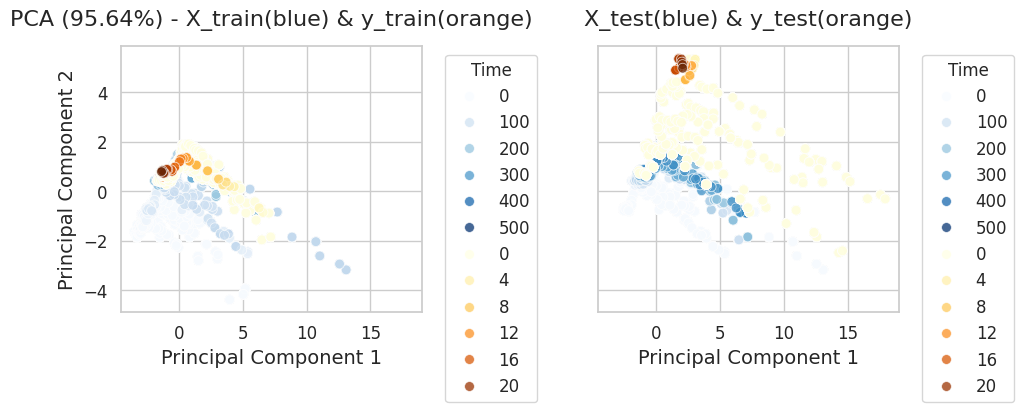

In [11]:
X_train, y_train, X_val, y_val, X_test, y_test, n_features = prepare_data(
    dataset_name="Illness_pred=24", context_length=512, forecasting_horizon=24
)
print(
    f"Illness_pred=24, size: {X_train.shape}, val size {X_val.shape}, test size {X_test.shape}"
)

X_train = (
    np.concatenate([X_train, X_val], axis=0).swapaxes(1, 2).reshape(-1, n_features)
)
y_train = (
    np.concatenate([y_train, y_val], axis=0).swapaxes(1, 2).reshape(-1, n_features)
)

X_test = X_test.swapaxes(1, 2).reshape(-1, n_features)
y_test = y_test.swapaxes(1, 2).reshape(-1, n_features)

# Apply PCA to X
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

y_pca = pca.transform(y_train)
X_test_pca = pca.transform(X_test)
y_test_pca = pca.transform(y_test)
# Compute the amount of explained variance by PCA
explained_variance = pca.explained_variance_ratio_

# Prepare data for plotting
max_time = X_train.shape[0] + y_train.shape[0]
X_pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
X_pca_df["batch_idx"] = X_pca_df.index // 512
X_pca_df["time"] = X_pca_df.index % 512


y_pca_df = pd.DataFrame(y_pca, columns=["PC1", "PC2"])
y_pca_df["batch_idx"] = y_pca_df.index // 24
y_pca_df["time"] = y_pca_df.index % 24

X_test_pca_df = pd.DataFrame(X_test_pca, columns=["PC1", "PC2"])
X_test_pca_df["batch_idx"] = X_test_pca_df.index // 512
X_test_pca_df["time"] = X_test_pca_df.index % 512

y_test_pca_df = pd.DataFrame(y_test_pca, columns=["PC1", "PC2"])
y_test_pca_df["batch_idx"] = y_test_pca_df.index // 24
y_test_pca_df["time"] = y_test_pca_df.index % 24


# Set style parameters for scientific paper
plt.rcParams.update(
    {
        "font.size": 14,
        "axes.titlesize": 16,
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
    }
)

# Plot the first two principal components
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

# Plot X
sns.scatterplot(
    data=X_pca_df,
    x="PC1",
    y="PC2",
    hue="time",
    palette="Blues",
    alpha=0.75,
    s=50,
    ax=ax1,
)
sns.scatterplot(
    data=y_pca_df,
    x="PC1",
    y="PC2",
    hue="time",
    palette="YlOrBr",
    alpha=0.75,
    s=50,
    ax=ax1,
)
ax1.set_title(
    f"PCA ({sum(explained_variance)*100:.2f}%) - X_train(blue) & y_train(orange)",
    pad=15,
)
ax1.set_xlabel("Principal Component 1", fontsize=14)
ax1.set_ylabel("Principal Component 2", fontsize=14)
ax1.legend(title="Time", title_fontsize=12, bbox_to_anchor=(1.05, 1), loc="upper left")

# Plot X @ W_star
sns.scatterplot(
    data=X_test_pca_df,
    x="PC1",
    y="PC2",
    hue="time",
    palette="Blues",
    alpha=0.75,
    s=50,
    ax=ax2,
)
sns.scatterplot(
    data=y_test_pca_df,
    x="PC1",
    y="PC2",
    hue="time",
    palette="YlOrBr",
    alpha=0.75,
    s=50,
    ax=ax2,
)
ax2.set_title("X_test(blue) & y_test(orange)", pad=15)
ax2.set_xlabel("Principal Component 1", fontsize=14)
ax2.set_ylabel("Principal Component 2", fontsize=14)
ax2.legend(title="Time", title_fontsize=12, bbox_to_anchor=(1.05, 1), loc="upper left")

# Adjust layout
plt.tight_layout(w_pad=3)

# Save with high DPI
plt.savefig(
    "/mnt/vdb/abenechehab/dicl-adapters/figures/from_notebooks/pca_illness.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.savefig(
    "/mnt/vdb/abenechehab/dicl-adapters/figures/from_notebooks/pca_illness.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [22]:
import torch

/tmp/ipykernel_3164644/1329030481.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  adapter = torch.load(adapter_path)


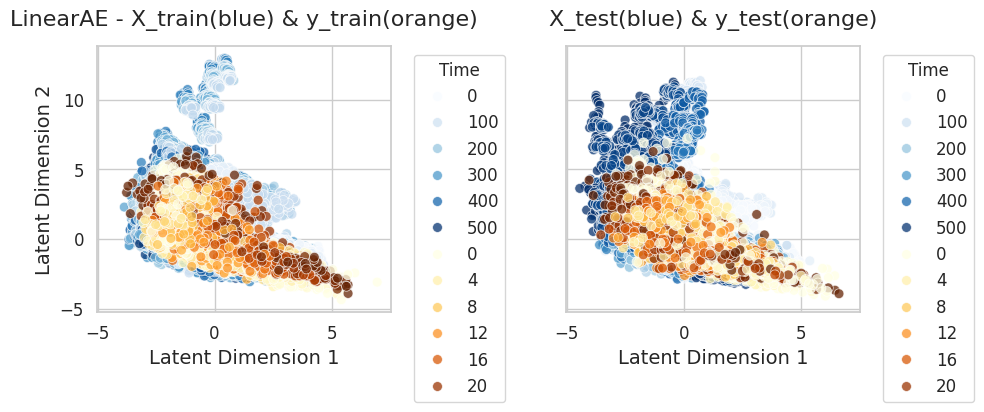

In [33]:
adapter_path = "/mnt/vdb/abenechehab/dicl-adapters/logs/logger/Illness_pred=24/20250127_021352_Illness_pred=24_VAE_MOMENT-1-small/n_comp_2/adapter.pt"
adapter = torch.load(adapter_path)

device = adapter.device

# Apply PCA to X
X_pca = (
    adapter.transform_torch(torch.from_numpy(X_train).float().to(device))
    .cpu()
    .detach()
    .numpy()
)
adapter.context_length = 24
y_pca = (
    adapter.transform_torch(torch.from_numpy(y_train).float().to(device))
    .cpu()
    .detach()
    .numpy()
)
adapter.context_length = 512
X_test_pca = (
    adapter.transform_torch(torch.from_numpy(X_test).float().to(device))
    .cpu()
    .detach()
    .numpy()
)
adapter.context_length = 24
y_test_pca = (
    adapter.transform_torch(torch.from_numpy(y_test).float().to(device))
    .cpu()
    .detach()
    .numpy()
)

# Prepare data for plotting
max_time = X_train.shape[0] + y_train.shape[0]
X_pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
X_pca_df["batch_idx"] = X_pca_df.index // 512
X_pca_df["time"] = X_pca_df.index % 512


y_pca_df = pd.DataFrame(y_pca, columns=["PC1", "PC2"])
y_pca_df["batch_idx"] = y_pca_df.index // 24
y_pca_df["time"] = y_pca_df.index % 24

X_test_pca_df = pd.DataFrame(X_test_pca, columns=["PC1", "PC2"])
X_test_pca_df["batch_idx"] = X_test_pca_df.index // 512
X_test_pca_df["time"] = X_test_pca_df.index % 512

y_test_pca_df = pd.DataFrame(y_test_pca, columns=["PC1", "PC2"])
y_test_pca_df["batch_idx"] = y_test_pca_df.index // 24
y_test_pca_df["time"] = y_test_pca_df.index % 24

# Set style parameters for scientific paper
plt.rcParams.update(
    {
        "font.size": 14,
        "axes.titlesize": 16,
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "legend.fontsize": 12,
    }
)

# Plot the first two principal components
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

# Plot X
sns.scatterplot(
    data=X_pca_df,
    x="PC1",
    y="PC2",
    hue="time",
    palette="Blues",
    alpha=0.75,
    s=50,
    ax=ax1,
)
sns.scatterplot(
    data=y_pca_df,
    x="PC1",
    y="PC2",
    hue="time",
    palette="YlOrBr",
    alpha=0.75,
    s=50,
    ax=ax1,
)
ax1.set_title(
    "LinearAE - X_train(blue) & y_train(orange)",
    pad=15,
)
ax1.set_xlabel("Latent Dimension 1", fontsize=14)
ax1.set_ylabel("Latent Dimension 2", fontsize=14)
ax1.legend(title="Time", title_fontsize=12, bbox_to_anchor=(1.05, 1), loc="upper left")

# Create custom norm with specific boundaries
norm = plt.Normalize(vmin=0, vmax=X_train.shape[0])
norm_y = plt.Normalize(vmin=X_train.shape[0], vmax=X_train.shape[0] + y_train.shape[0])

# Plot X @ W_star
sns.scatterplot(
    data=X_test_pca_df,
    x="PC1",
    y="PC2",
    hue="time",
    # size="batch_idx",
    palette="Blues",
    alpha=0.75,
    s=50,
    ax=ax2,
)
sns.scatterplot(
    data=y_test_pca_df,
    x="PC1",
    y="PC2",
    hue="time",
    palette="YlOrBr",
    alpha=0.75,
    s=50,
    ax=ax2,
)
ax2.set_title("X_test(blue) & y_test(orange)", pad=15)
ax2.set_xlabel("Latent Dimension 1", fontsize=14)
ax2.set_ylabel("Latent Dimension 2", fontsize=14)
ax2.legend(title="Time", title_fontsize=12, bbox_to_anchor=(1.05, 1), loc="upper left")

# Adjust layout
plt.tight_layout(w_pad=3)

# Save with high DPI
plt.savefig(
    "/mnt/vdb/abenechehab/dicl-adapters/figures/from_notebooks/linear_latent_illness.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.savefig(
    "/mnt/vdb/abenechehab/dicl-adapters/figures/from_notebooks/linear_latent_illness.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

# Calibration plots

In [4]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap

<Figure size 640x480 with 0 Axes>

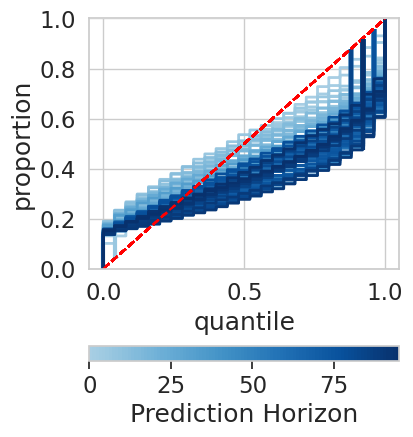

In [22]:
n_features = 7
forecasting_horizon = 96

# path = "/mnt/vdb/abenechehab/dicl-adapters/logs/logger/Illness_pred=24/20250127_200503_Illness_pred=24_linearVAE_MOMENT-1-small/n_comp_7"
# path = "/mnt/vdb/abenechehab/dicl-adapters/logs/latest/Illness_pred=24/20250128_003638_Illness_pred=24_linearVAE_MOMENT-1-small/n_comp_7"
# path = "/mnt/vdb/abenechehab/dicl-adapters/logs/latest/Illness_pred=24/20250130_013026_Illness_pred=24_VAE_MOMENT-1-small/n_comp_7"
# path = "/mnt/vdb/abenechehab/dicl-adapters/logs/latest/Illness_pred=24/20250129_230935_Illness_pred=24_linearlVAE_MOMENT-1-small/n_comp_7"
path = "/mnt/vdb/abenechehab/dicl-adapters/logs/latest/ETTh1_pred=96/20250129_170744_ETTh1_pred=96_linearVAE_MOMENT-1-small/n_comp_5"
# path = "/mnt/vdb/abenechehab/dicl-adapters/logs/latest/ETTh1_pred=96/20250128_054628_ETTh1_pred=96_linearVAE_MOMENT-1-small/n_comp_7"
# path = "/mnt/vdb/abenechehab/dicl-adapters/logs/latest/ETTh1_pred=96/20250128_113137_ETTh1_pred=96_VAE_MOMENT-1-small/n_comp_7"

all_kss, all_ks_quantiles = (
    np.load(f"{path}/ks.npy"),
    np.load(f"{path}/ks_quantiles.npy"),
)

sns.set_theme(style="whitegrid", font_scale=1.5)
sns.set_palette("colorblind")
sns.despine()

feature_names = [f"f{i}" for i in range(n_features)]

fig, axes = plt.subplots(
    1,  # (n_features // 3) + 1,
    1,  # 3,
    figsize=(4, 5),
    # gridspec_kw={"wspace": 0.2, "hspace": 0.2},
    # sharex=True,
    # sharey=True,
)
axes = list(np.array(axes).flatten())
# Create a colormap
palette = sns.color_palette("Blues", n_colors=forecasting_horizon + 50)[
    -forecasting_horizon:
]

cmap = ListedColormap(palette)
norm = Normalize(vmin=0, vmax=forecasting_horizon - 1)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
for h in range(forecasting_horizon):
    kss, ks_quantiles = all_kss[:, h], all_ks_quantiles[:, h]
    for dim in [0]:  # range(n_features):
        calibration.ks_cdf(
            ks_quantiles,
            dim,
            ax=axes[dim],
            verbose=0,
            pot_cdf_uniform=True,
            color=sns.color_palette(palette, n_colors=forecasting_horizon)[h],
            label=f"{h}",
            color_uniform="red",
        )
        # axes[dim].set_title(f"{feature_names[dim]}")
        axes[dim].grid(True)
        if dim >= 3 * (n_features // 3):
            axes[dim].set_xlabel("quantile")
            if dim % 3 == 1:
                axes[dim].legend(
                    title="prediction horizon",
                    loc="upper center",
                    bbox_to_anchor=(0.5, -0.38),
                    ncol=6,
                    fontsize=9,
                )
        # else:
        #     axes[dim].legend(
        #         loc="upper center", bbox_to_anchor=(0.5, -0.18), ncol=6, fontsize=9
        #     )
        if dim % 3 == 0:
            axes[dim].set_ylabel("proportion")
# Add the colorbar
cbar = fig.colorbar(sm, ax=axes, orientation="horizontal", pad=0.2)
cbar.set_label("Prediction Horizon")

axes[-1].set_xlabel("quantile")
plt.savefig(
    "/mnt/vdb/abenechehab/dicl-adapters/figures/from_notebooks/calibration.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

SyntaxError: invalid syntax (3022984677.py, line 4)

/tmp/ipykernel_3422621/775156447.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


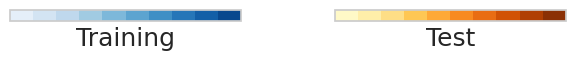

In [28]:
# Create figure
fig, ax = plt.subplots(1, 2, figsize=(8, 1), gridspec_kw={"wspace": 0.1})

# Create colormaps for training and test
colors_train = sns.color_palette("Blues", n_colors=10)
colors_test = sns.color_palette("YlOrBr", n_colors=10)

# Add colorbar for training data
norm_train = Normalize(vmin=0, vmax=9)
sm_train = ScalarMappable(cmap=ListedColormap(colors_train), norm=norm_train)
sm_train.set_array([])
cbar1 = plt.colorbar(sm_train, ax=ax[0], orientation="horizontal", label="Training")
cbar1.ax.set_xticklabels([])  # Remove tick labels
cbar1.ax.set_xticks([])  # Remove tick labels

# Add colorbar for test data
norm_test = Normalize(vmin=0, vmax=9)
sm_test = ScalarMappable(cmap=ListedColormap(colors_test), norm=norm_test)
sm_test.set_array([])
cbar2 = plt.colorbar(sm_test, ax=ax[1], orientation="horizontal", label="Test")
cbar2.ax.set_xticklabels([])  # Remove tick labels
cbar2.ax.set_xticks([])  # Remove tick labels

# Remove axes content
ax[0].remove()
ax[1].remove()

# Adjust layout
plt.tight_layout()

plt.savefig(
    "/mnt/vdb/abenechehab/dicl-adapters/figures/from_notebooks/legend_colormaps.pdf",
    dpi=300,
    bbox_inches="tight",
)

plt.show()